# Take Home Challenge - Ultimate Technologies inc.

In [147]:
# import packages
import os
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import numpy as np
import json
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
import warnings
warnings.filterwarnings("ignore")

# Part   1   ‑   Exploratory   data   analysis

The   attached    logins.json    file   contains   (simulated)   timestamps   of   user   logins   in   a   particular
geographic   location.   Aggregate   these   login   counts   based   on   15­ minute   time   intervals,   and
visualize   and   describe   the   resulting   time   series   of   login   counts   in   ways   that   best   characterize   the underlying   patterns   of   the   demand.   Please   report/illustrate   important   features   of   the   demand,
such   as   daily   cycles.   If   there   are   data   quality   issues,   please   report   them.

In [148]:
#loading the JSON data
data_store = json.load(open('logins.json'))

In [149]:
#building the data frame
logins = json_normalize(data_store, record_path='login_time')

In [150]:
#name the first col "date"
logins.columns = ['date']

In [151]:
# create temp column with count of 1 per record
logins['count'] = 1

In [152]:
# convert to true date timetampe
logins['date'] = pd.to_datetime(logins['date'])

In [153]:
#set index
logins.set_index('date', inplace=True)

In [154]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
count    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


In [155]:
# Create the df of 15 min. time frame samples
frequency_15 = logins.resample('15T').sum()

In [156]:
frequency_15.head()

,count
date,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


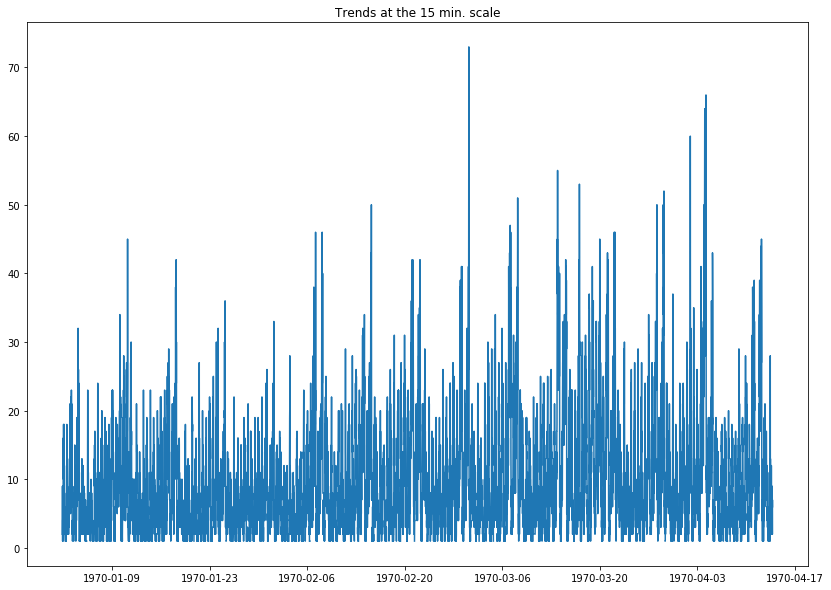

In [157]:
#plot frequency at 15 minute interval
plt.plot(frequency_15['count'])
plt.title('Trends at the 15 min. scale');

As we can see from the plot above there is far too much dencity at this scale to obtain much in the way of useful insights. We could attempt to change the scale to a higher timeframe e.g. daily, or we might be able to highlight certain time frames to look for consistent spikes on given days e.g. Monday vs Saturday. 

In [158]:
logins['day_of_week'] = logins.index.map(lambda x: x.weekday())

In [159]:
def show_trends(df, title):
    new_df = df

    for day in sorted(list(new_df['day_of_week'].unique())):

        temp = new_df[new_df['day_of_week'] == day]
        temp.drop('day_of_week', axis=1, inplace=True)
        temp['count'] = 1
        temp = temp.resample('15T').sum()
        
        
        if day in [0,1,2,3]:
            color = 'blue'
        else:
            color = 'orange'
        plt.plot(temp, color=color)
        plt.title(title)
        plt.xticks(rotation=40)


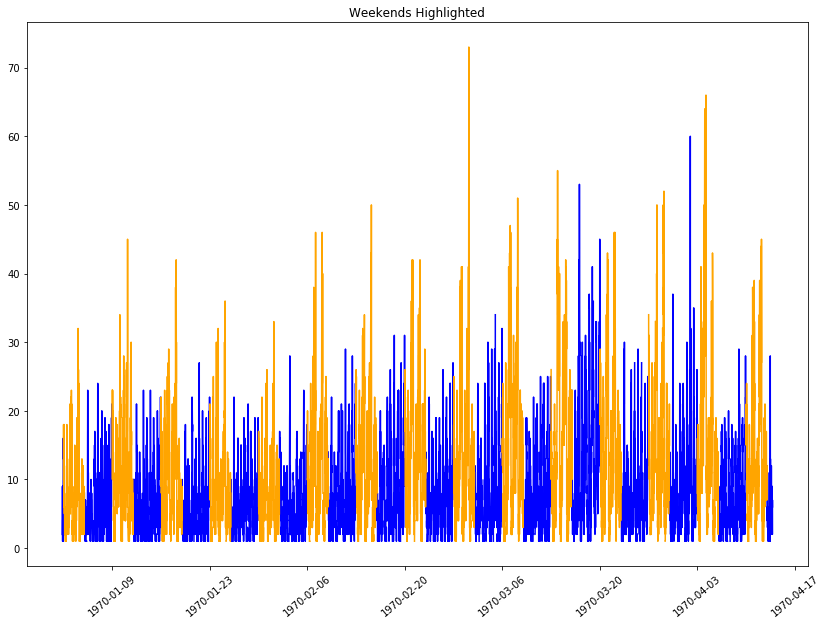

In [160]:
show_trends(logins, title='Weekends Highlighted')


We can see a consistent spike in traffic on the weekends.

In [161]:
# create the same thing at the daily level
frequency_D = logins.resample('D').count()

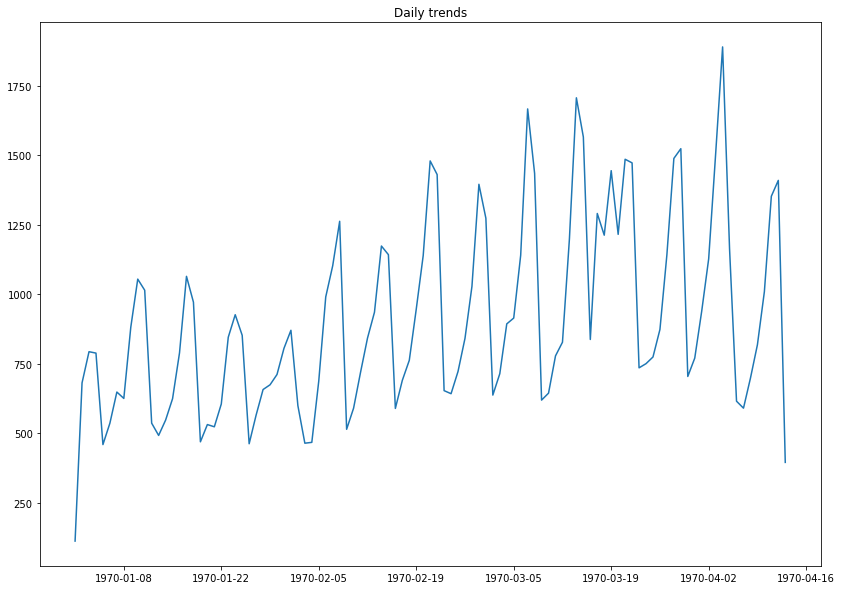

In [162]:
# plot frequency at the daily level
plt.plot(frequency_D['count'])
plt.title('Daily trends');

We can see a gneral trend of increasing logins through the begining of April and then a decrease into the middle of April. For the record it looks like we do **not have data for the entire month of April** which precents use from making a full assessment of that month. 

In [163]:
# let refine the data point a little by adding features such as rounded hour of the day and day of the week for easy splitting. 
logins['month'] = (pd.DatetimeIndex(logins.index).month)
logins['day_of_week'] = (pd.DatetimeIndex(logins.index).dayofweek)
logins['hour'] = (pd.DatetimeIndex(logins.index).hour)
logins.head()

,count,day_of_week,month,hour
date,,,,
1970-01-01 20:13:18,1,3,1,20
1970-01-01 20:16:10,1,3,1,20
1970-01-01 20:16:37,1,3,1,20
1970-01-01 20:16:36,1,3,1,20
1970-01-01 20:26:21,1,3,1,20


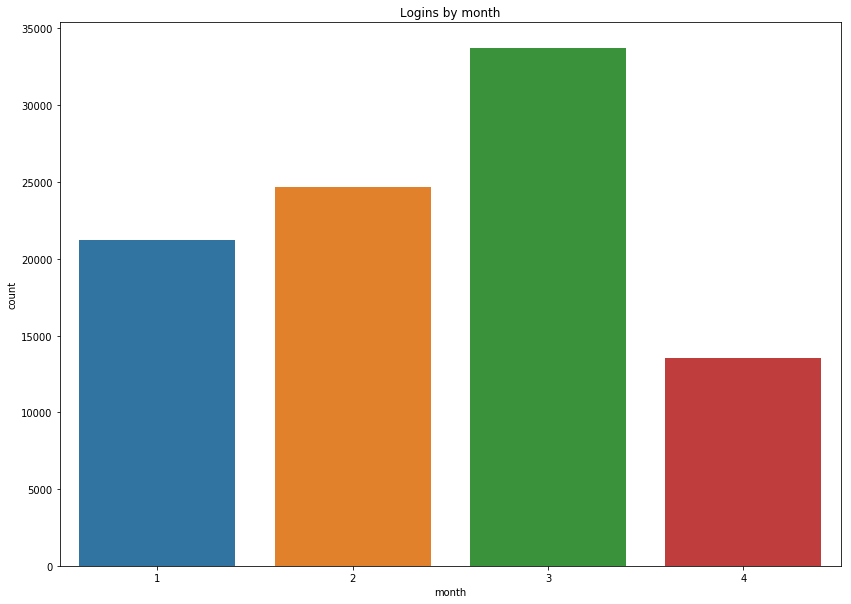

In [164]:
sns.countplot(logins.month)
plt.title('Logins by month')

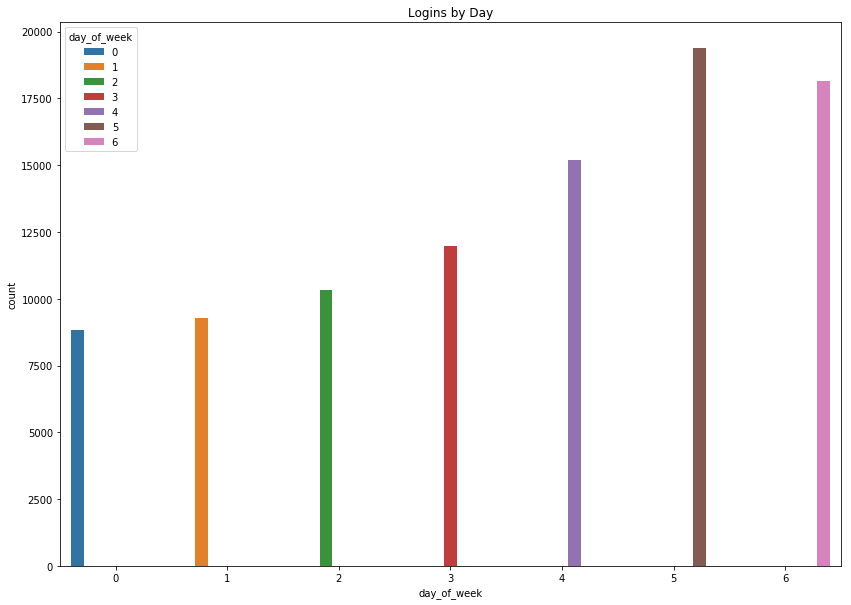

In [165]:
# count of all logins by day of the week
sns.countplot(logins.day_of_week, hue=logins['day_of_week'])
plt.title('Logins by Day');

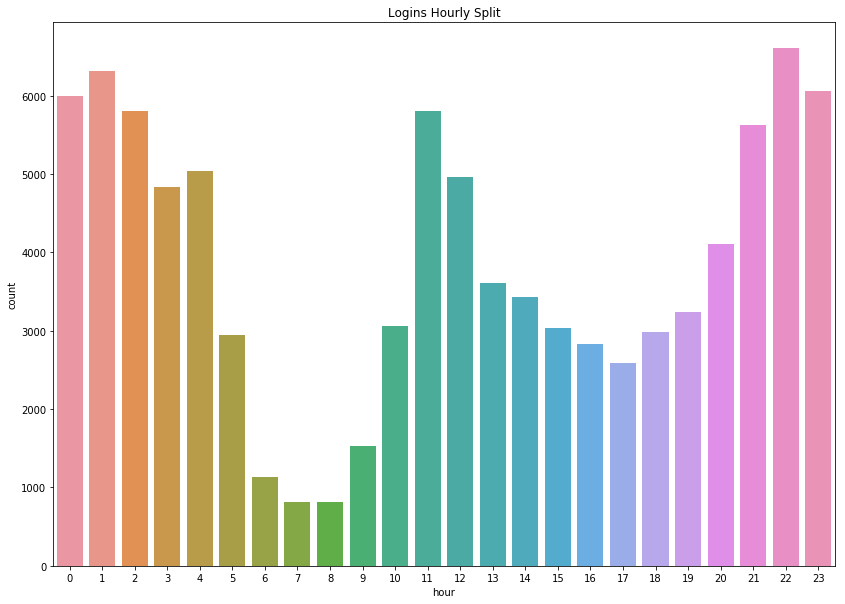

In [166]:
# counts of logins by hour for entire data
sns.countplot(logins.hour)
plt.title('Logins Hourly Split');

We can see more activity betweek 9pm and 2 am with a spike around lunch time. This type of investigation could also be segmented out into subsections for each month and per days of the week i.e. we could see if the overall trend has any notable exceptions or if it changed durring a particular month. 


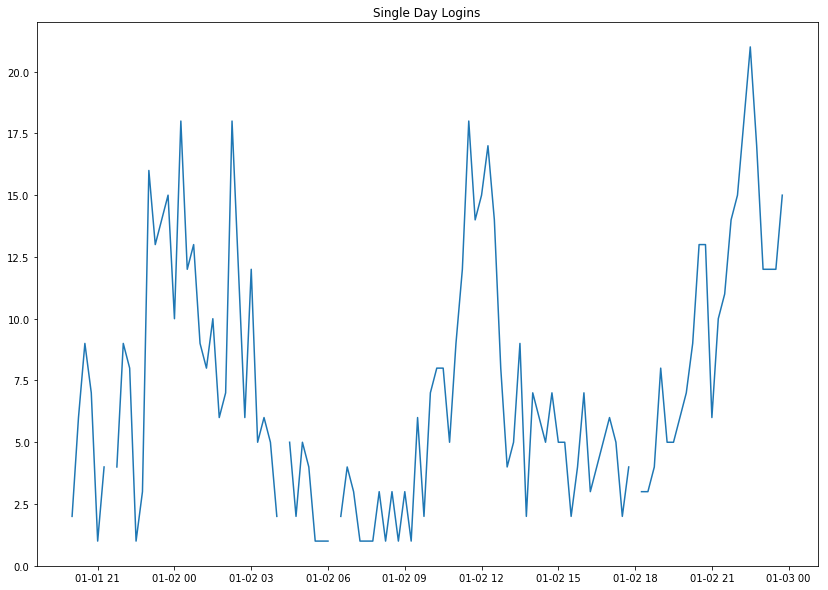

In [167]:
# flow of logins for a single day
plt.plot(frequency_15['1970-01-01': '1970-01-02'])
plt.title('Single Day Logins');

Taking a look at the flow of logins throughout a single day. There is too much data to do this for every day but performing it on a handful of days or days where we spot odd trends might be useful.

## Summary:

From the above information there seems to be the most system demand from 9pm to 2am with relative downtime inbetween save for a spike durring lunch (11-1). We can see an increase in logins since January and thus would need to keep an eye on system load so as to be able to meet the demand as more people attemp to login to the system. If system downtime is planned it would be best to have this done from either 5am - 10am or 1pm - 7pm when system demand is relativly lower and would likely cause proportionaly less disruption to services. 

# Part   2   ‑   Experiment   and   metrics   design

The   neighboring   cities   of   Gotham   and   Metropolis   have   complementary   circadian   rhythms:   on
weekdays,   Ultimate   Gotham   is   most   active   at   night,   and   Ultimate   Metropolis   is   most   active
during   the   day.   On   weekends,   there   is   reasonable   activity   in   both   cities.
However,   a   toll   bridge,   with   a   two ­way   toll,   between   the   two   cities   causes   driver   partners   to   tend
to   be   exclusive   to   each   city.   The   Ultimate   managers   of   city   operations   for   the   two   cities   have
proposed   an   experiment   to   encourage   driver   partners   to   be   available   in   both   cities,   by
reimbursing   all   toll   costs.
1. What   would   you   choose   as   the   key   measure   of   success   of   this   experiment   in
encouraging   driver   partners   to   serve   both   cities,   and   why   would   you   choose   this   metric?
2. Describe   a   practical   experiment   you   would   design   to   compare   the   effectiveness   of   the
proposed   change   in   relation   to   the   key   measure   of   success.   Please   provide   details   on: 
a. how   you   will   implement   the   experiment
b. what   statistical   test(s)   you   will   conduct   to   verify   the   significance   of   the
observation
c. how   you   would   interpret   the   results   and   provide   recommendations   to   the   city
operations   team   along   with   any   caveats.

**1)** Weekend engagement (use) for drivers would liekly be a better indicator when compared to weekday use. Weekday traffic is likely to be impeded by many factors including the large differential in peak times. The weekends provide an oportune time for drivers to be able to flow back and forth. Another possibility would be to get drivers to shift their schedules working some days in one city and nights in the other.

As for a measure of success this could be a little tricky. We could monitor revenues, but we are not directly interested in revenues as a single outcome here. We are looking to increase the number of drivers that serve both cities. As for this I would recommend tracking driver traffic from one city to the other when not in service. i.e. when they are traversing to the other city to start work. Tracking can be done either directly through cameras that track lisense plates or indirectly though reporting. 

**2)** 

We would need to begin by tracking baseline data of the flow and use of drivers e.g. by lisence plate. This would need to be done for as many of the drivers as possible e.g. all if feasible. We would want both weekday and weekend use data. Following this we could institute the new policy and track the resulting changes. We would want to give drivers incentives that both encourage them to take passengers from one city to the other and to travel from one city to the other for the entire shift. e.g. once on the other side they stay for their entire shift. 

Once the information is collected we would perform a statistical evaluation to see if there is a difference between the before and after data sets. e.g. did we see an increase in our usage metrics, and do we see drivers from one city going to the other and providing service. 

# Part   3   ‑   Predictive   modeling

Ultimate   is   interested   in   predicting   rider   retention.   To   help   explore   this   question,   we   have
provided   a   sample   dataset   of   a   cohort   of   users   who   signed   up   for   an   Ultimate   account   in
January   2014.   The   data   was   pulled   several   months   later;   we   consider   a   user   retained   if   they
were   “active”   (i.e.   took   a   trip)   in   the   preceding   30   days.
We   would   like   you   to   use   this   data   set   to   help   understand   what   factors   are   the   best   predictors
for   retention,   and   offer   suggestions   to   operationalize   those   insights   to   help   Ultimate.
The   data   is   in   the   attached   file   ultimate_data_challenge.json.   See   below   for   a   detailed
description   of   the   dataset.   Please   include   any   code   you   wrote   for   the   analysis   and   delete   the
dataset   when   you   have   finished   with   the   challenge.
1. Perform   any   cleaning,   exploratory   analysis,   and/or   visualizations   to   use   the   provided
data   for   this   analysis   (a   few   sentences/plots   describing   your   approach   will   suffice).   What
fraction   of   the   observed   users   were   retained?
2. Build   a   predictive   model   to   help   Ultimate   determine   whether   or   not   a   user   will   be   active
in   their   6th   month   on   the   system.   Discuss   why   you   chose   your   approach,   what
alternatives   you   considered,   and   any   concerns   you   have.   How   valid   is   your   model?
Include   any   key   indicators   of   model   performance.
3. Briefly   discuss   how   Ultimate   might   leverage   the   insights   gained   from   the   model   to
improve   its   long­ term   rider   retention   (again,   a   few   sentences   will   suffice).

<img src='Screenshot_4.png'>

In [168]:
# load the data
import json
file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()

In [169]:
# see what we have
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [170]:
# check for missing values
df.isnull().any()

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
dtype: bool

In [171]:
# check the format of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Will need to go through several of the columns and address some potential issues. 1) Missing data from the phone and ratings columns. 2) we will need to examine the trip data to determine what the current retention rate is. 

In [172]:
# see what the phone user data looks like
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [173]:
# fill with the predominant phone type, probably won't be a major factor either way
df['phone'] = df['phone'].fillna('iPhone')

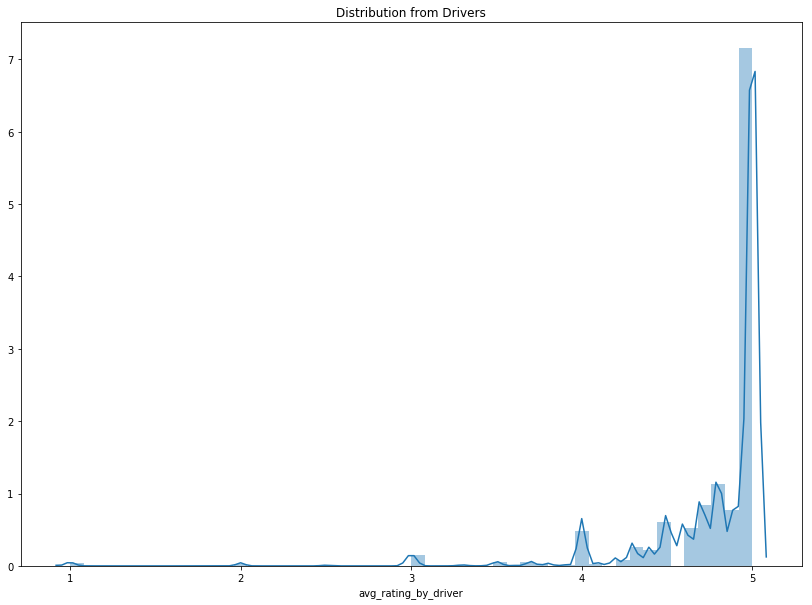

In [175]:
sns.distplot(df[df['avg_rating_by_driver'].notnull()]['avg_rating_by_driver'])
plt.title('Distribution from Drivers');

In [176]:
# Given the distribution we will fill missing values with the median value
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())

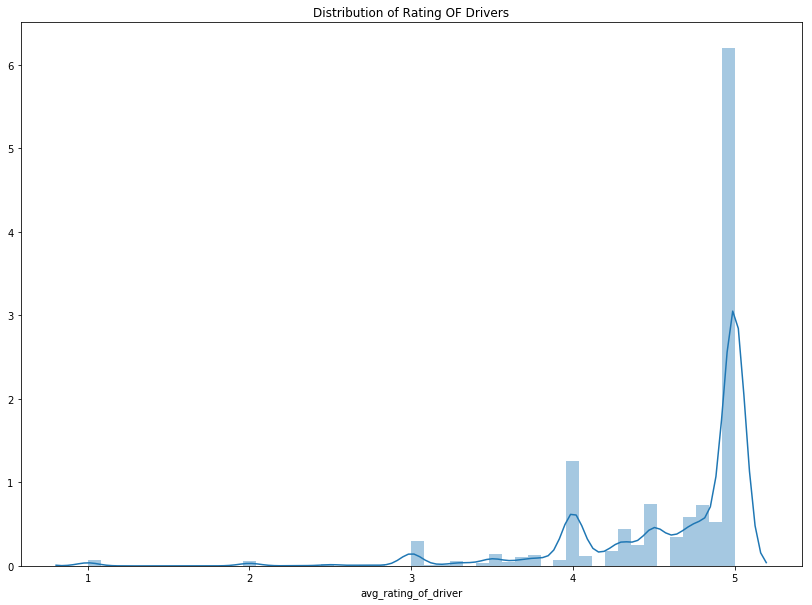

In [178]:
sns.distplot(df[df['avg_rating_of_driver'].notnull()]['avg_rating_of_driver'])
plt.title('Distribution of Rating OF Drivers');

In [179]:
# Given the distribution we will fill the missing values with the median
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())

In [180]:
# Checking the date range
print('First trip:', min(pd.to_datetime(df['last_trip_date'])), 
      'Last trip:', max(pd.to_datetime(df['last_trip_date'])))

First trip: 2014-01-01 00:00:00 Last trip: 2014-07-01 00:00:00


In [181]:
# time to take a look at the retention numbers, Will need to apply time stamp to simplify things
df['signup_date'] = df['signup_date'].apply(lambda x: pd.Timestamp(x))

df['last_trip_date'] = df['last_trip_date'].apply(lambda x: pd.Timestamp(x))

In [182]:
# use function to sift through the datetime data quickly
df['retained'] = df['last_trip_date'].apply(lambda x: 1 if x >= pd.Timestamp('2014-06-01', tz=None) else 0)

In [183]:
# Getting the specific retention numbers, 0 not retained, 1 retained
retained = df['retained'].value_counts()
retained_percent = retained[1]/len(df)
print(retained, '\n', '\n','Retention Rate:', retained_percent)

0    31196
1    18804
Name: retained, dtype: int64 
 
 Retention Rate: 0.37608


So we can see a retention rate of about 37%, not so great.

In [184]:
df['ultimate_black_user'].head() 

0     True
1    False
2    False
3     True
4    False
Name: ultimate_black_user, dtype: bool

In [185]:
# drop out the date information to simplify things
df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

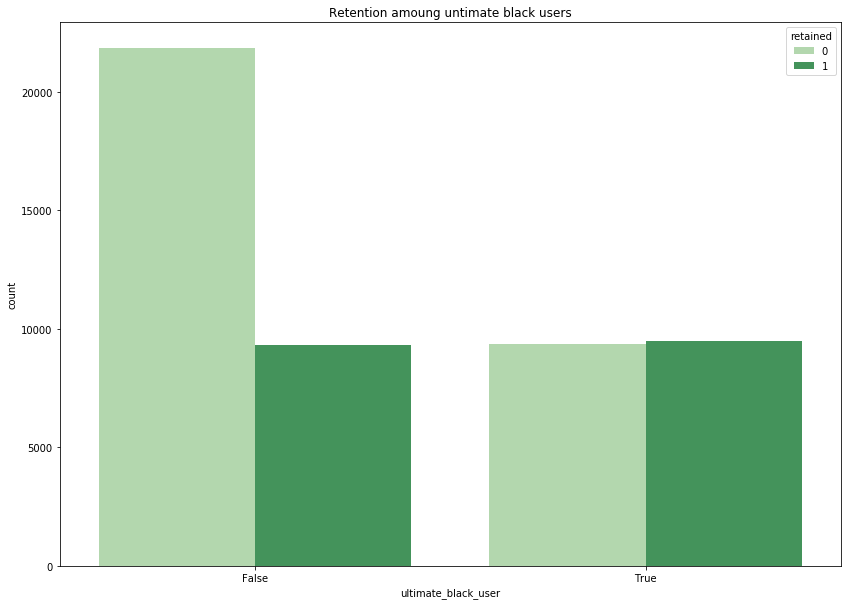

In [186]:
# 0 and 1 on the color meand deliniates retained v. not, X axis is ultimate black v not
sns.countplot(x='ultimate_black_user', data=df, hue='retained', palette="Greens")
plt.title("Retention amoung untimate black users");

As we can see those who use ultimate black are far more liekly to be retained than those who do not. 

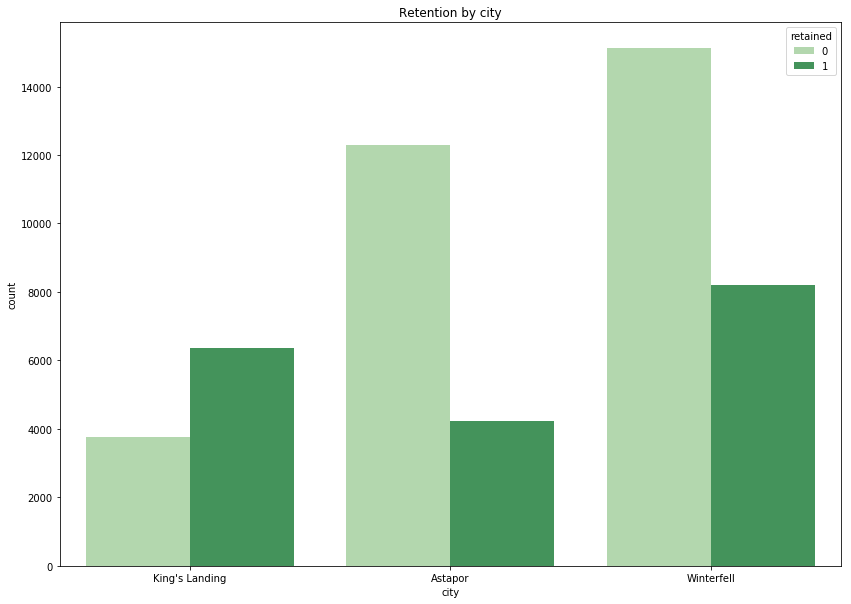

In [187]:
# colors are retained v. not, axis is city of residence 
sns.countplot(x='city', data=df, hue='retained', palette="Greens")
plt.title("Retention by city");

Here we can see King's landing is doing well. We could probably benefit by a more detailed analysis of how we are doing things right in Kings Landing and where we are going wrong in Astapor. e.g. are the city dynamics different, is there a lack of or quality impairment to the service in astapor?

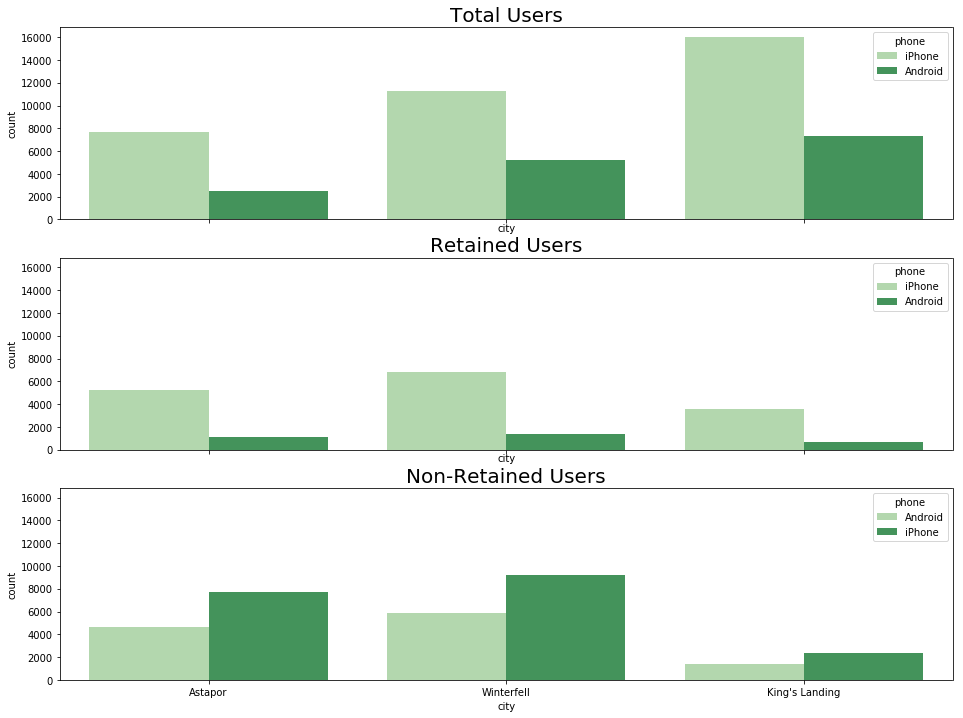

In [188]:
# Maybe the type of cell phone makes a differencce
df_retained = df[(df['retained'] == 1)]
df_not_retained = df[(df['retained'] == 0)] 

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True, sharey=True)

sns.countplot(x='city', data=df, hue='phone', palette="Greens", ax=ax1)
ax1.set_title("Total Users", fontsize='20')

sns.countplot(x='city', data=df_retained, hue='phone', palette="Greens", ax=ax2)
ax2.set_title("Retained Users", fontsize='20')

sns.countplot(x='city', data=df_not_retained, hue='phone', palette="Greens", ax=ax3)
ax3.set_title("Non-Retained Users", fontsize='20');

From the above it does not look like there is any major discrepancy with a particular group of cell useers e.g. a specific problem with the android app compared to the IPhone. 

# Prediction

In [189]:
# pre-process the data
df = pd.get_dummies(df, prefix='is')

In [190]:
# set the features and target
X = df.drop(['retained', 'avg_surge'], axis=1)

y = df['retained']

In [191]:
# split for train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

This model is highly versitile, gives several hyperparameters to tune, and will give the ability to pull out feature importances very easily. 

In [192]:
# initial model test
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(verbose=True, n_estimators=200, random_state=7)
gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1           1.2796            4.59s
         2           1.2437            4.37s
         3           1.2134            3.57s
         4           1.1856            3.43s
         5           1.1623            4.07s
         6           1.1431            3.93s
         7           1.1256            3.79s
         8           1.1105            3.67s
         9           1.0912            3.58s
        10           1.0790            3.91s
        20           0.9957            3.76s
        30           0.9628            3.46s
        40           0.9453            3.22s
        50           0.9348            3.00s
        60           0.9274            2.81s
        70           0.9221            2.58s
        80           0.9182            2.35s
        90           0.9154            2.13s
       100           0.9126            1.93s
       200           0.8906            0.00s


0.79400000000000004

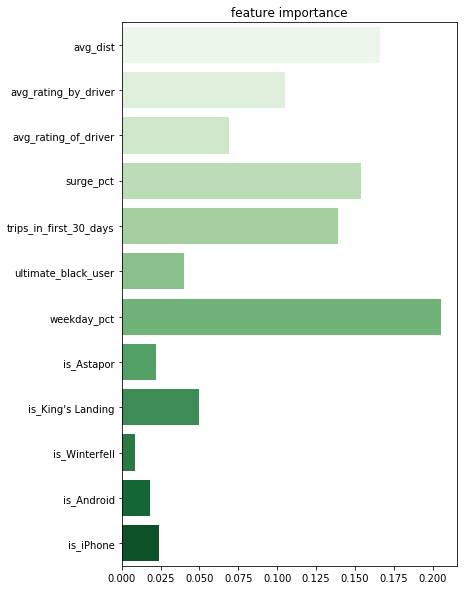

In [201]:
# examine the feature importances
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=gbc.feature_importances_, orient='h', palette='Greens')
plt.title('feature importance');

Here we can spot a few things. 1) weekday uage is a big factor, maybe they are more reliant on the service e.g. work commute. 2) distance traveled. Interestingly the midel ranged being an ultimate black users much lower than I would have anticipated from the earlier finding. However, this could be that among the overall population of samples one a pleurality were ultimate black users. 

## Tuning Hyper-Parameters

In [194]:
'''from sklearn.model_selection import GridSearchCV

param_1 = {'n_estimators':range(20,81,10)}

grid_1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                            min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=7), 
                                            param_grid = param_1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

grid_1.fit(X_train,y_train)'''

"from sklearn.model_selection import GridSearchCV\n\nparam_1 = {'n_estimators':range(20,81,10)}\n\ngrid_1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,\n                                            min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=7), \n                                            param_grid = param_1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)\n\ngrid_1.fit(X_train,y_train)"

In [195]:
# grid_1.grid_scores_, grid_1.best_params_, grid_1.best_score_

In [196]:
'''param_2 = {'max_depth':range(3,12,2), 'min_samples_split':range(200,800,200)}

grid_2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt', 
                                            subsample=0.8, random_state=7), param_grid = param_2, scoring='roc_auc',
                                              n_jobs=4,iid=False, cv=5)

grid_2.fit(X_train, y_train)

grid_2.grid_scores_, grid_2.best_params_, grid_2.best_score_'''

"param_2 = {'max_depth':range(3,12,2), 'min_samples_split':range(200,800,200)}\n\ngrid_2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt', \n                                            subsample=0.8, random_state=7), param_grid = param_2, scoring='roc_auc',\n                                              n_jobs=4,iid=False, cv=5)\n\ngrid_2.fit(X_train, y_train)\n\ngrid_2.grid_scores_, grid_2.best_params_, grid_2.best_score_"

In [197]:
gbc_2 = GradientBoostingClassifier(learning_rate=0.1,
                                   n_estimators=400,
                                   max_features='sqrt', 
                                   max_depth=6, 
                                   min_samples_split=600,
                                   min_samples_leaf=40, 
                                   random_state=7)

In [198]:
gbc_2.fit(X_train, y_train)
train_score = gbc_2.score(X_train, y_train)
test_score = gbc_2.score(X_test, y_test)
print('Train score:', train_score, '|' , 'Test Score:', test_score)

Train score: 0.818775 | Test Score: 0.7958


The current model seems to be topping out at about 79% accuraccy even with hyperparameter tuning. It could be possible to squeeze an extra few percent of accuracy out with a more thourough parameter tuning, but this is highly computationally and time expensive. It might also be possible to acheive better with results with an alternate model and/or further feature/data tuning.

To begin with I would recommend comtinueing perks for the groups that currently show the highest retention i.e. the weekday users and the Ultimate black users. It would be advisable to maintain if not enhance further services for these groups. Second, a city based alaysis going further indepth than informatioin available here, into the working of our program in Kings landing and astapor to figure what spevifically is going right and wrong respectivly. 

## Random Forrest Classifier

In [199]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [200]:
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.75290000000000001